In [152]:
import sys
from commonfunctions import *
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.color import rgb2gray
from scipy.ndimage import interpolation as inter
from skimage.morphology import binary_erosion, binary_dilation

import cv2
from utlis import *
import functools

In [153]:
def skew_correction(image, showTrace):
        
    # correct skew
    def RotationAngle(binImg):
        def find_score(arr, angle):
            data = inter.rotate(arr, angle, reshape=False, order=0)
            hist = np.sum(data, axis=1)
            score = np.sum((hist[1:] - hist[:-1]) ** 2)
            return hist, score
        delta = 1
        limit = 50
        angles = np.arange(-limit, limit+delta, delta)
        scores = []
        for angle in angles:
            hist, score = find_score(binImg, angle)
            scores.append(score)
        best_score = max(scores)
        best_angle = angles[scores.index(best_score)]
        return best_angle

    def RotateImage(thresh2,angle):
        (h, w) = thresh2.shape
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        rotated_image = cv2.warpAffine(thresh2, M, (w, h),borderMode=cv2.BORDER_CONSTANT,borderValue=(255,255,255))
        return rotated_image

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 11, 5) # increasing box size will make elements delated in high ratio
    rotated = RotateImage(thresh2,RotationAngle(thresh2))
    if(showTrace):
        show_images([rotated])
    
    return rotated

In [154]:
def trepozoidal_correction(image, showTrace): 

    def biggestContour(contours):
        biggest = np.array([])
        max_area = 0
        for i in contours:
            area = cv2.contourArea(i)
            if area > 10000:
                peri = cv2.arcLength(i, True)
                approx = cv2.approxPolyDP(i, 0.02 * peri, True)
                if area > max_area and len(approx) == 4:
                    biggest = approx
                    max_area = area
        return biggest,max_area

    # Image modification
    img_original = image.copy()
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 50, 15, 15)
    edged = cv2.Canny(gray, 50, 50)
    kernel = np.ones((7, 7))
    dilatedImg = cv2.dilate(edged, kernel, iterations=2)
    edged = cv2.erode(dilatedImg, kernel, iterations=1)
    # cv2.imwrite("mine.jpg",edged)


    # Contour detection
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ContourFrame = img.copy()
    ContourFrame = cv2.drawContours(ContourFrame, contours, -1,  (0, 255, 0), 10)

    biggest, max_area = biggestContour(contours)

    new_img = cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)
    if(showTrace): show_images([ContourFrame,new_img])

    # Pixel values in the original image
    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    max_width = max(int(bottom_width), int(top_width))
    # max_height = max(int(right_height), int(left_height))
    max_height = int(max_width * 1.414)  # for A4

    # Desired points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

    # Image shape modification for hstack
    gray = np.stack((gray,) * 3, axis=-1)
    edged = np.stack((edged,) * 3, axis=-1)

    if(showTrace):
        show_images([img_original, gray, edged])
        show_images([ContourFrame])
        show_images([ img, img_output])
    return img_output

In [155]:
def CheckAlgo(image,showTrace):
    img = cv2.resize(image, (480*2, 640*2))
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgThre= cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
       cv2.THRESH_BINARY_INV, 1001, 5)

    imgThre2 = cv2.bitwise_not(imgThre)
    imgThre3 =cv2.medianBlur(imgThre2,3)
    w, h = imgThre3.shape

    if(showTrace):
        show_images([img,imgThre,imgThre2,imgThre3]) 

    top = np.sum(imgThre3[0:20, 0:h])/(20*h)
    bottom = np.sum(imgThre3[w-20:w, 0:h])/(20*h)
    right = np.sum(imgThre3[0:w, 0:20])/(20*w)
    left = np.sum(imgThre3[0:w, h-20:h])/(20*w)
    check = (top+bottom+right+left)/4
    return check

In [156]:
# #initializing
# def preprocessing (image, showTrace = False):
#     check = CheckAlgo(image,showTrace)
#     if(check<100):
#         img = trepozoidal_correction(image, showTrace)
#         # img = trap(image)
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#         img= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#             cv2.THRESH_BINARY, 51, 12)
#     else:
#         img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#         img= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#             cv2.THRESH_BINARY, 101,5)
#         # img = skew_correction(image, showTrace)
        
#         img = cv2.medianBlur(img, 15)
#     return img


#initializing
def preprocessing (image, showTrace = False):
    check = CheckAlgo(image,showTrace)
    img = image.copy()
    if(check<100):
        img = trepozoidal_correction(image, showTrace)

    if showTrace: show_images([img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    bluredImg = cv2.GaussianBlur(img, (5, 5), 1.2)
    bluredImg = cv2.medianBlur(img, 5)
   
    blockSize = image.shape[1]//10
    
    if(blockSize % 2 != 1):
        blockSize = blockSize + 1
    
    thresholdedImg= cv2.adaptiveThreshold(bluredImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY,blockSize= blockSize, C= 25)
    if showTrace: show_images([thresholdedImg])
  
    kernel = cv2.getStructuringElement(shape= cv2.MORPH_ELLIPSE, ksize= (5,5))
    thresholdedImg = cv2.morphologyEx(thresholdedImg, cv2.MORPH_OPEN, kernel, iterations=3)
    thresholdedImg = cv2.morphologyEx(thresholdedImg, cv2.MORPH_ERODE, cv2.getStructuringElement(shape= cv2.MORPH_CROSS, ksize= (3,3)), iterations=1)
    # thresholdedImg = cv2.medianBlur(thresholdedImg, 11)
    
    if showTrace: show_images([thresholdedImg])
    return thresholdedImg

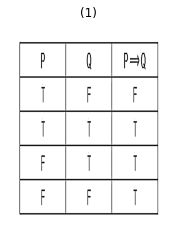

In [157]:

# img = cv2.imread("grade sheet/2.jpg") 

# print(sorted)
# print(counter)
# plt.figure(),plt.imshow(img),plt.title('Hough Lines'),plt.axis('off')
# plt.show()